# Measuring Future Care Home Risk in England - An Analysis

This example notebook looks to combine care homes location data across England with COVID-19 incidences at a local authority level to derive a 'Care Home Risk' metric which will inform us about the areas where care homes may be vulnerable to infection as well as displaying information on the specific care home names and postcodes within such areas.

We will first work with the care home locations dataset to derive care home counts and information for each local authority before combining it with case data.

The following imports will be necessary for this analysis:

## Imports

In [488]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from pandas.io.json import json_normalize
import geopandas as gpd
import descartes
from shapely import wkt
from shapely.geometry import Point, Polygon
from sklearn.preprocessing import StandardScaler
from cycler import cycler
plt.rcParams.update(plt.rcParamsDefault)

## Derive Care Home Counts Dataset

To derive Care Home Counts across England, we first need to use the provided API that lists all care home locations in England as of 2016.

In [489]:
response = json.loads(requests.get("https://iqapi.azurewebsites.net/api/EnglandCareHomes").text)

In [490]:
for value in response.values():
    data = value

In [491]:
df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')

In [492]:
df.head()

,Code1,Care_Home_Name,Code2,Code3,Address1,Address2,Address3,Town_City,County,Postcode
0,VL000,Admiral House,Y53,Q36,Cliff Road,Wandsworth,None,London,Greater London,SW16 1PA
1,VL001,Focus Project,Y56,Q71,29 Akerman Road,None,None,London,Greater London,SW9 6SN
2,VL002,Alan Morkill House,Y53,Q36,88 St Mark's Road,None,None,London,Greater London,W10 6BY
3,VL003,Albion House,Y56,Q71,8-12 Albion Way,Lewisham,None,London,Greater London,SE13 6BT
4,VL004,Albany House,Y56,Q71,75 Southwood Road,New Eltham,None,London,Greater London,SE9 3QE


We then need to map the postcodes of each care home to which local authority in England they're located in. We begin this by using the relevant mapping data. The first one maps lower tier local authority to upper tier local authorities. You can download this data here: https://geoportal.statistics.gov.uk/datasets/lower-tier-local-authority-to-upper-tier-local-authority-december-2019-lookup-in-england-and-wales

In [493]:
mapping1 = pd.read_csv('LTLAUTLAnew.csv')

In [494]:
mapping1.head()

,LTLA19CD,LTLA19NM,UTLA19CD,UTLA19NM,FID
0,E08000002,Bury,E08000002,Bury,1
1,E06000001,Hartlepool,E06000001,Hartlepool,2
2,E08000003,Manchester,E08000003,Manchester,3
3,E08000004,Oldham,E08000004,Oldham,4
4,E06000002,Middlesbrough,E06000002,Middlesbrough,5


The second dataset maps UK postcodes to the lower tier local authority. Remember that the end result we want is to know the upper tier local authority that each care home is present in. We can download this data from the following link: https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-february-2020-lookup-in-the-uk (Warning - This is a particularly large file that may take a while to load in. I would recommend that you merge this data with the care home locations data immediately so you quickly remove the irrelevant postcodes and reduce the file size accordingly for future use). The following code steps will do this.

In [495]:
mapping2 = pd.read_csv('PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv', engine = 'python')

In [496]:
mapping2.head()

,pcd7,pcd8,pcds,dointr,doterm,usertype,oa11cd,lsoa11cd,msoa11cd,ladcd,lsoa11nm,msoa11nm,ladnm,ladnmw
0,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606.0,0,S00090303,S01006514,S02001237,S12000033,"Cults, Bieldside and Milltimber West - 02","Cults, Bieldside and Milltimber Wes",Aberdeen City,NaN
1,AB1 0AB,AB1 0AB,AB1 0AB,198001,199606.0,0,S00090303,S01006514,S02001237,S12000033,"Cults, Bieldside and Milltimber West - 02","Cults, Bieldside and Milltimber Wes",Aberdeen City,NaN
2,AB1 0AD,AB1 0AD,AB1 0AD,198001,199606.0,0,S00090399,S01006514,S02001237,S12000033,"Cults, Bieldside and Milltimber West - 02","Cults, Bieldside and Milltimber Wes",Aberdeen City,NaN
3,AB1 0AE,AB1 0AE,AB1 0AE,199402,199606.0,0,S00091322,S01006853,S02001296,S12000034,"Dunecht, Durris and Drumoak - 01","Dunecht, Durris and Drumoak",Aberdeenshire,NaN
4,AB1 0AF,AB1 0AF,AB1 0AF,199012,199207.0,1,S00090299,S01006511,S02001236,S12000033,Culter - 06,Culter,Aberdeen City,NaN


Make sure the postcodes are in the same format by removing the spaces. At this point we can select only the columns we need too.

In [497]:
mapping2 = mapping2[['pcds', 'ladcd', 'ladnm']]

Create a list that contains all England postcodes that contain a care home and filter the postcode mapping data by this list so we can create a smaller dataset of the relevant postcodes only.

In [498]:
CHpostcodes = list(df['Postcode'])

In [499]:
mapping3 = mapping2[mapping2['pcds'].isin(CHpostcodes)]

In [500]:
mapping3 = mapping3.rename(columns={'ladcd': 'LTLA19CD', 'pcds' : 'Postcode'})

In [501]:
mapping3.head()

,Postcode,LTLA19CD,ladnm
38988,AL1 1TA,E07000240,St Albans
38992,AL1 1TF,E07000240,St Albans
39106,AL1 2BE,E07000240,St Albans
39226,AL1 2NH,E07000240,St Albans
39231,AL1 2NQ,E07000240,St Albans


We now merge this with the first mapping dataset to get postcodes mapped to upper tier local authorities.

In [502]:
mergedmappings = pd.merge(mapping3, mapping1, how = 'left', on = 'LTLA19CD')

In [503]:
mergedmappings.head()

,Postcode,LTLA19CD,ladnm,LTLA19NM,UTLA19CD,UTLA19NM,FID
0,AL1 1TA,E07000240,St Albans,St Albans,E10000015,Hertfordshire,214.0
1,AL1 1TF,E07000240,St Albans,St Albans,E10000015,Hertfordshire,214.0
2,AL1 2BE,E07000240,St Albans,St Albans,E10000015,Hertfordshire,214.0
3,AL1 2NH,E07000240,St Albans,St Albans,E10000015,Hertfordshire,214.0
4,AL1 2NQ,E07000240,St Albans,St Albans,E10000015,Hertfordshire,214.0


In [504]:
df.head()

,Code1,Care_Home_Name,Code2,Code3,Address1,Address2,Address3,Town_City,County,Postcode
0,VL000,Admiral House,Y53,Q36,Cliff Road,Wandsworth,None,London,Greater London,SW16 1PA
1,VL001,Focus Project,Y56,Q71,29 Akerman Road,None,None,London,Greater London,SW9 6SN
2,VL002,Alan Morkill House,Y53,Q36,88 St Mark's Road,None,None,London,Greater London,W10 6BY
3,VL003,Albion House,Y56,Q71,8-12 Albion Way,Lewisham,None,London,Greater London,SE13 6BT
4,VL004,Albany House,Y56,Q71,75 Southwood Road,New Eltham,None,London,Greater London,SE9 3QE


In [505]:
carehomelocs = pd.merge(mergedmappings, df, how = 'left', on = 'Postcode')

In [506]:
carehomelocs = carehomelocs[['Postcode', 'LTLA19CD', 'ladnm', 'Care_Home_Name', 'UTLA19CD', 'UTLA19NM']]

In [507]:
carehomelocs.head()

,Postcode,LTLA19CD,ladnm,Care_Home_Name,UTLA19CD,UTLA19NM
0,AL1 1TA,E07000240,St Albans,Stuart House,E10000015,Hertfordshire
1,AL1 1TF,E07000240,St Albans,25 Mile House Lane,E10000015,Hertfordshire
2,AL1 2BE,E07000240,St Albans,Leyland House,E10000015,Hertfordshire
3,AL1 2BE,E07000240,St Albans,Woodside Residential Home,E10000015,Hertfordshire
4,AL1 2NH,E07000240,St Albans,12 Tavistock Avenue,E10000015,Hertfordshire


In [508]:
carehomelocs.columns = ['Postcode', 'LTLA_CODE', 'LTLA_NAME', 'Care Home Name', 'UTLA_CODE', 'UTLA_NAME']

In [509]:
carehomelocs.head()

,Postcode,LTLA_CODE,LTLA_NAME,Care Home Name,UTLA_CODE,UTLA_NAME
0,AL1 1TA,E07000240,St Albans,Stuart House,E10000015,Hertfordshire
1,AL1 1TF,E07000240,St Albans,25 Mile House Lane,E10000015,Hertfordshire
2,AL1 2BE,E07000240,St Albans,Leyland House,E10000015,Hertfordshire
3,AL1 2BE,E07000240,St Albans,Woodside Residential Home,E10000015,Hertfordshire
4,AL1 2NH,E07000240,St Albans,12 Tavistock Avenue,E10000015,Hertfordshire


For future use, it would be advisable to run the following command to save the above table as a csv as stated earlier. The code has been commented out.

In [510]:
#carehomelocs.to_csv('carehomelocations.csv', index = False)

As an additional step before we begin the true analysis, we can also perform some manipulations of the dataset so we can obtain a list of care home information concerning each local authority. This may be useful down the line should we wish to refer to care homes in a single local authority that have a high risk of infection. It will provide the name and postcode of each care home in a tuple format.

The first step is to combine the Care Home Name and Postcode column to generate a new column named 'Care Home Info'.

In [511]:
carehomelocs['Care Home Info'] =  tuple(zip(carehomelocs['Care Home Name'], carehomelocs['Postcode']))

In [512]:
carehomelocs = carehomelocs.drop_duplicates()

In [513]:
carehomelocs.head()

,Postcode,LTLA_CODE,LTLA_NAME,Care Home Name,UTLA_CODE,UTLA_NAME,Care Home Info
0,AL1 1TA,E07000240,St Albans,Stuart House,E10000015,Hertfordshire,"(Stuart House, AL1 1TA)"
1,AL1 1TF,E07000240,St Albans,25 Mile House Lane,E10000015,Hertfordshire,"(25 Mile House Lane, AL1 1TF)"
2,AL1 2BE,E07000240,St Albans,Leyland House,E10000015,Hertfordshire,"(Leyland House, AL1 2BE)"
3,AL1 2BE,E07000240,St Albans,Woodside Residential Home,E10000015,Hertfordshire,"(Woodside Residential Home, AL1 2BE)"
4,AL1 2NH,E07000240,St Albans,12 Tavistock Avenue,E10000015,Hertfordshire,"(12 Tavistock Avenue, AL1 2NH)"


To obtain care home count and information for each local authority, we can perform a couple of groupby operations and merge them together. The below steps of code highlight this process

In [514]:
#Adjust if you want Lower or Upper tier local authorities
LA_CH_Count = carehomelocs.groupby('UTLA_CODE')['UTLA_NAME'].count().reset_index()

In [515]:
LA_Combined_Tuples = carehomelocs.groupby('UTLA_CODE')['Care Home Info'].agg(lambda x: x.tolist()).reset_index()

In [516]:
def removeDuplicates(lst): 
      
    return [t for t in (set(tuple(i) for i in lst))] 

In [517]:
LA_Combined_Tuples['Care Home Info'] = LA_Combined_Tuples['Care Home Info'].apply(lambda x: removeDuplicates(x))

In [518]:
carehomecounts = pd.merge(LA_CH_Count, LA_Combined_Tuples, how = 'left', on = 'UTLA_CODE')

In [519]:
carehomecounts.head()

,UTLA_CODE,UTLA_NAME,Care Home Info
0,E06000001,41,"[(Dinsdale Lodge Nursing Home, TS25 1BG), (Gre..."
1,E06000002,64,"[(Parkville Care Centre, TS1 4HA), (Highfield ..."
2,E06000003,73,"[(Bridge Court Bungalow, TS6 0LD), (St Peter's..."
3,E06000004,72,"[(54 Darlington Road, TS18 5EW), (Cherry Tree ..."
4,E06000005,50,"[(Fairhaven, DL3 7HA), (The Grange Residential..."


In [520]:
carehomecounts.columns = [['UTLA_CODE', 'CARE_HOME_COUNT', 'CARE_HOME_INFO']]

In [521]:
carehomecounts.head()

,UTLA_CODE,CARE_HOME_COUNT,CARE_HOME_INFO
0,E06000001,41,"[(Dinsdale Lodge Nursing Home, TS25 1BG), (Gre..."
1,E06000002,64,"[(Parkville Care Centre, TS1 4HA), (Highfield ..."
2,E06000003,73,"[(Bridge Court Bungalow, TS6 0LD), (St Peter's..."
3,E06000004,72,"[(54 Darlington Road, TS18 5EW), (Cherry Tree ..."
4,E06000005,50,"[(Fairhaven, DL3 7HA), (The Grange Residential..."


The above table is the result we were looking for, and shows the care home count and the name and postcode of every care home in that local authority.

## Merge Care Homes Data

Once we've derived the Care Home Counts dataset from the initial API data, we can then merge this with our COVID-19 incidences data.

We load in the data from the API and change the column names below.

In [522]:
response = json.loads(requests.get("https://iqapi.azurewebsites.net/api/CoronaVirusCase").text)

In [523]:
for value in response.values():
    data = value

In [524]:
df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')

In [525]:
df.head()

,AREA_CODE,AREA_TYPE,SPECIMEN_DATE,LAB_CONFIRMED_CASES,PREVIOUS_DAILY_CASES,CHANGE_IN_DAILY_CASES,CUMULATIVE_LAB_CONFIRMED_CASES,PREVIOUS_CUMULATIVE_CASES,CHANGE_IN_CUMULATIVE_CASES
0,E07000029,ltla,2020-09-22T00:00:00,0,None,None,402,None,None
1,E06000052,ltla,2020-09-22T00:00:00,1,None,None,1191,None,None
2,E06000047,ltla,2020-09-22T00:00:00,0,None,None,4316,None,None
3,E06000005,ltla,2020-09-22T00:00:00,1,None,None,717,None,None
4,E07000108,ltla,2020-09-22T00:00:00,0,None,None,751,None,None


We then want to merge the cases data with the demography API below since we're interested in the populations of the local authorities. This is so we can calculate a COVID-19 incidence rate per 100,000 later instead of relying on raw case numbers.

In [526]:
response = json.loads(requests.get("https://iqapi.azurewebsites.net/api/UKPopulationDemographicData2018").text)

In [527]:
for value in response.values():
    data = value

In [528]:
dem_data = pd.DataFrame.from_dict(json_normalize(data), orient='columns')

In [529]:
dem_data.head()

,AREA_CODE,AREA_NAME,GEOGRAPHY1,ALL_AGES,COL_0,COL_1,COL_2,COL_3,COL_4,COL_5,...,COL_85,COL_86,COL_87,COL_88,COL_89,COL_90,AREA_IN_SQ_KM,ESTIMATED_POPULATION_MID2018,PEOPLE_PER_SQ_KM_2018,Mid_2018
0,K02000001,UNITED KINGDOM,Country,"66,435,550","745,263","770,614","796,314","797,183","804,654","823,204",...,"251,440","231,588","207,887","181,142","152,411","584,024","242,749","66,435,550",274,40.1
1,K03000001,GREAT BRITAIN,Country,"64,553,909","722,107","746,644","771,397","772,403","779,741","797,905",...,"245,130","226,054","202,985","176,983","148,734","570,886","228,956","64,553,909",282,40.2
2,K04000001,ENGLAND AND WALES,Country,"59,115,809","669,797","692,792","715,313","715,338","722,190","739,193",...,"224,531","207,075","186,581","163,196","137,054","528,959","151,045","59,115,809",391,40
3,E92000001,ENGLAND,Country,"55,977,178","637,834","659,890","681,032","680,758","687,213","703,391",...,"211,152","195,247","175,993","153,958","129,352","499,276","130,309","55,977,178",430,39.9
4,E12000001,NORTH EAST,Region,"2,657,909","27,275","28,355","29,293","29,138","30,008","30,795",...,"10,697","9,648","8,783","7,436","5,939","21,889","8,574","2,657,909",310,41.8


In [530]:
dem_data = dem_data[['AREA_CODE', 'AREA_NAME', 'ESTIMATED_POPULATION_MID2018']]

In [531]:
dem_data.head()

,AREA_CODE,AREA_NAME,ESTIMATED_POPULATION_MID2018
0,K02000001,UNITED KINGDOM,"66,435,550"
1,K03000001,GREAT BRITAIN,"64,553,909"
2,K04000001,ENGLAND AND WALES,"59,115,809"
3,E92000001,ENGLAND,"55,977,178"
4,E12000001,NORTH EAST,"2,657,909"


The population column is in the wrong format so we need to remove the commas and adjust the data type to integers.

In [532]:
dem_data.columns = ['AREA_CODE', 'NAME', 'POPULATION']

In [533]:
dem_data['POPULATION'] = dem_data['POPULATION'].str.replace(',', '').astype(int)

In [534]:
dem_data.head()

,AREA_CODE,NAME,POPULATION
0,K02000001,UNITED KINGDOM,66435550
1,K03000001,GREAT BRITAIN,64553909
2,K04000001,ENGLAND AND WALES,59115809
3,E92000001,ENGLAND,55977178
4,E12000001,NORTH EAST,2657909


The merge of cases table and demography table is below.

In [535]:
df = pd.merge(df, dem_data, how = 'left', on = 'AREA_CODE')

In [536]:
df.head()

,AREA_CODE,AREA_TYPE,SPECIMEN_DATE,LAB_CONFIRMED_CASES,PREVIOUS_DAILY_CASES,CHANGE_IN_DAILY_CASES,CUMULATIVE_LAB_CONFIRMED_CASES,PREVIOUS_CUMULATIVE_CASES,CHANGE_IN_CUMULATIVE_CASES,NAME,POPULATION
0,E07000029,ltla,2020-09-22T00:00:00,0,None,None,402,None,None,Copeland,68424
1,E06000052,ltla,2020-09-22T00:00:00,1,None,None,1191,None,None,Cornwall,565968
2,E06000047,ltla,2020-09-22T00:00:00,0,None,None,4316,None,None,County Durham,526980
3,E06000005,ltla,2020-09-22T00:00:00,1,None,None,717,None,None,Darlington,106566
4,E07000108,ltla,2020-09-22T00:00:00,0,None,None,751,None,None,Dover,116969


In [537]:
df = df[['NAME', 'AREA_CODE', 'SPECIMEN_DATE', 'LAB_CONFIRMED_CASES', 'CUMULATIVE_LAB_CONFIRMED_CASES', 'POPULATION']]

In [538]:
df.head()

,NAME,AREA_CODE,SPECIMEN_DATE,LAB_CONFIRMED_CASES,CUMULATIVE_LAB_CONFIRMED_CASES,POPULATION
0,Copeland,E07000029,2020-09-22T00:00:00,0,402,68424
1,Cornwall,E06000052,2020-09-22T00:00:00,1,1191,565968
2,County Durham,E06000047,2020-09-22T00:00:00,0,4316,526980
3,Darlington,E06000005,2020-09-22T00:00:00,1,717,106566
4,Dover,E07000108,2020-09-22T00:00:00,0,751,116969


When then merge the two datasets to form the base dataset for the analysis.

In [539]:
carehomecounts.columns = ['AREA_CODE', 'CARE_HOME_COUNT', 'CARE_HOME_INFO']

In [540]:
df = pd.merge(df, carehomecounts, how='left', on='AREA_CODE')

The below table is what we want. We can see that the data is currently reported by local authority and by date.

In [541]:
df.head()

,NAME,AREA_CODE,SPECIMEN_DATE,LAB_CONFIRMED_CASES,CUMULATIVE_LAB_CONFIRMED_CASES,POPULATION,CARE_HOME_COUNT,CARE_HOME_INFO
0,Copeland,E07000029,2020-09-22T00:00:00,0,402,68424,NaN,NaN
1,Cornwall,E06000052,2020-09-22T00:00:00,1,1191,565968,309.0,"[(Trevean, PL25 5HE), (Restgarth Care Home, PL..."
2,County Durham,E06000047,2020-09-22T00:00:00,0,4316,526980,234.0,"[(Highview House, DL16 7JT), (River View, DH8 ..."
3,Darlington,E06000005,2020-09-22T00:00:00,1,717,106566,50.0,"[(Fairhaven, DL3 7HA), (The Grange Residential..."
4,Dover,E07000108,2020-09-22T00:00:00,0,751,116969,NaN,NaN


For the time being, we are only interested in upper tier local authorities. So as a result the data will not be populated for areas that are not at an upper tier level. We can just therefore delete rows that contain any null values so we're left with upper tier local authorities only.

In [542]:
df = df.dropna(axis = 0)

At this point we need to remember that we're only interested in recent incidences of COVID-19 to determine care home risk. Let's look at data over the past 14 days, so perform the following filter operations:

In [543]:
df['SPECIMEN_DATE']= pd.to_datetime(df['SPECIMEN_DATE'])

In [544]:
latestday = np.sort(df['SPECIMEN_DATE'].unique())[-2]

In [545]:
start_date = latestday - pd.Timedelta(days=14)
end_date = latestday

In [546]:
date_filter = (df['SPECIMEN_DATE'] > start_date) & (df['SPECIMEN_DATE'] <= end_date)

In [547]:
df = df.loc[date_filter]

We can see that the data covers only the latest 14 days by printing the unique dates in the dataframe we just filtered.

In [548]:
df['SPECIMEN_DATE'].unique()

array(['2020-09-21T00:00:00.000000000', '2020-09-20T00:00:00.000000000',
       '2020-09-19T00:00:00.000000000', '2020-09-18T00:00:00.000000000',
       '2020-09-17T00:00:00.000000000', '2020-09-16T00:00:00.000000000',
       '2020-09-15T00:00:00.000000000', '2020-09-14T00:00:00.000000000',
       '2020-09-13T00:00:00.000000000', '2020-09-12T00:00:00.000000000',
       '2020-09-11T00:00:00.000000000', '2020-09-10T00:00:00.000000000',
       '2020-09-09T00:00:00.000000000', '2020-09-08T00:00:00.000000000'],
      dtype='datetime64[ns]')

In this analysis we would prefer to work with cases as a proportion of the population of the local authority. We therefore calculate daily and cumulative incidence per 100,000 columns. We also do this to care home count, so we can better establish the density of the care home population in each local authority.

In [549]:
df['DAILY_INCIDENCE_PER_100000'] = (df['LAB_CONFIRMED_CASES']/df['POPULATION'])*100000

In [550]:
df['CUMULATIVE_INCIDENCE_PER_100000'] = (df['CUMULATIVE_LAB_CONFIRMED_CASES']/df['POPULATION'])*100000

In [551]:
df['CARE_HOMES_PER_100000'] = (df['CARE_HOME_COUNT']/df['POPULATION'])*100000

In [552]:
df.head()

,NAME,AREA_CODE,SPECIMEN_DATE,LAB_CONFIRMED_CASES,CUMULATIVE_LAB_CONFIRMED_CASES,POPULATION,CARE_HOME_COUNT,CARE_HOME_INFO,DAILY_INCIDENCE_PER_100000,CUMULATIVE_INCIDENCE_PER_100000,CARE_HOMES_PER_100000
477,Cheshire East,E06000049,2020-09-21,19,2730,380790,135.0,"[(Orcadia, SK12 2HE), (Bexton Court Community ...",4.989627,716.930592,35.452612
478,Cheshire West and Chester,E06000050,2020-09-21,11,2477,340502,110.0,"[(Dee House, CH1 4LB), (Mount Pleasant Nursing...",3.230524,727.455345,32.305243
480,Central Bedfordshire,E06000056,2020-09-21,5,1491,283606,79.0,"[(Rosewood Court, LU6 3DX), (New Meppershall C...",1.763009,525.729357,27.855546
482,Blackpool,E06000009,2020-09-21,7,1292,139305,107.0,"[(Abbey Care, FY4 1JB), (Red Rose, FY1 4HY), (...",5.024945,927.461326,76.809878
484,Bath and North East Somerset,E06000022,2020-09-21,6,495,192106,86.0,"[(Bathampton Manor, BA2 6TS), (Residential Car...",3.123276,257.670245,44.766952


## Derive Care Home Risk Dataframe from Base Dataset

We shall begin this process by devising a Care Home Risk metric. This metric will be a function of the average daily incidence of COVID-19 over the past 14 days, the average change in the same metric as well as the cumulative incidence of COVID-19 throughout the pandemic. The inclusion of the final number is based on the assumption of herd immunity, in that if there have been a greater number of previous cases in an area, then we assume that there is less possibility for the virus to spread and as such the risk to care homes will be reduced.

With these assumptions, we will therefore place the cumulative incidence number in the denominator of the calculation. This will allow for a higher cumulative incidence to generate a lower care home risk all else being equal.

Create Change in Daily Incidence column below

In [553]:
CHRisk = df.sort_values(by = 'SPECIMEN_DATE')

In [554]:
CHRisk['DAILY_INCIDENCE_CHANGE']=CHRisk.groupby('AREA_CODE')['DAILY_INCIDENCE_PER_100000'].diff()

In [555]:
change = CHRisk.groupby('AREA_CODE')['DAILY_INCIDENCE_CHANGE', 'NAME'].mean().reset_index()

In [556]:
change.columns = ['AREA_CODE', 'AVG_DAILY_CHANGE_14_DAYS']

In [557]:
CHRisk = pd.merge(CHRisk, change, how = 'left', on = 'AREA_CODE')

In [558]:
CHRisk = CHRisk.drop('DAILY_INCIDENCE_CHANGE', axis = 1)

In [559]:
CHRisk = CHRisk.fillna(0)

Create 14 day Average Cases Column

In [560]:
avgcases = CHRisk.groupby('AREA_CODE')['DAILY_INCIDENCE_PER_100000', 'NAME'].mean().reset_index()

In [561]:
avgcases.columns = ['AREA_CODE', 'AVG_INCIDENCE_14_DAYS']

In [562]:
CHRisk = pd.merge(CHRisk, avgcases, how = 'left', on = 'AREA_CODE')

Create Latest Cumulative Cases Column

In [563]:
cumcases = CHRisk.groupby(['AREA_CODE'])['CUMULATIVE_INCIDENCE_PER_100000'].max().reset_index()

In [564]:
cumcases.columns = ['AREA_CODE', 'LATEST_CUMULATIVE_INCIDENCE']

In [565]:
CHRisk = pd.merge(CHRisk, cumcases, how = 'left', on = 'AREA_CODE')

In [566]:
CHRisk.head()

,NAME,AREA_CODE,SPECIMEN_DATE,LAB_CONFIRMED_CASES,CUMULATIVE_LAB_CONFIRMED_CASES,POPULATION,CARE_HOME_COUNT,CARE_HOME_INFO,DAILY_INCIDENCE_PER_100000,CUMULATIVE_INCIDENCE_PER_100000,CARE_HOMES_PER_100000,AVG_DAILY_CHANGE_14_DAYS,AVG_INCIDENCE_14_DAYS,LATEST_CUMULATIVE_INCIDENCE
0,Cheshire West and Chester,E06000050,2020-09-08,15,2264,340502,110.0,"[(Dee House, CH1 4LB), (Mount Pleasant Nursing...",4.405260,664.900647,32.305243,-0.043509,4.782854,727.455345
1,Havering,E09000016,2020-09-08,13,1225,257810,90.0,"[(The Lodge, RM5 2ES), (Dury Falls, RM11 3XA),...",5.042473,475.156123,34.909429,-0.143660,4.322120,530.623327
2,Haringey,E09000014,2020-09-08,10,1018,270624,104.0,"[(Ernest Dene Residential Care Home, N10 2JX),...",3.695164,376.167672,38.429703,-0.082115,3.325647,419.031571
3,Hartlepool,E06000001,2020-09-08,8,725,93242,41.0,"[(Dinsdale Lodge Nursing Home, TS25 1BG), (Gre...",8.579825,777.546599,43.971601,0.238328,9.728908,905.171489
4,Greenwich,E09000011,2020-09-08,8,1128,286186,62.0,"[(Emmanuel Care Services, SE28 8AP), (Marlboro...",2.795385,394.149260,21.664232,-0.051766,2.271250,423.151377


Since we are combining our columns into a metric, it would be preferable to standardise the columns of interest using Min Max scaling. We also need to group our results by the local authority area code now we have made the calculations we need.

The below code shows this process.

In [567]:
CHRisk = CHRisk.groupby(['AREA_CODE','NAME'])['CARE_HOMES_PER_100000', 'CARE_HOME_INFO', 'POPULATION', 'AVG_INCIDENCE_14_DAYS',
                            'LATEST_CUMULATIVE_INCIDENCE',
                            'AVG_DAILY_CHANGE_14_DAYS'].mean().reset_index()

In [568]:
CHRisk.head()

,AREA_CODE,NAME,CARE_HOMES_PER_100000,POPULATION,AVG_INCIDENCE_14_DAYS,LATEST_CUMULATIVE_INCIDENCE,AVG_DAILY_CHANGE_14_DAYS
0,E06000001,Hartlepool,43.971601,93242,9.728908,905.171489,0.238328
1,E06000002,Middlesbrough,45.537017,140545,7.165981,947.739158,0.289877
2,E06000003,Redcar and Cleveland,53.394579,136718,4.075124,648.049269,0.189631
3,E06000004,Stockton-on-Tees,36.508749,197213,5.686383,639.410181,0.056341
4,E06000005,Darlington,46.919280,106566,4.289763,671.884091,0.139020


In [569]:
CHRisk["AVG_INCIDENCE_14_DAYS_MM"] = (CHRisk["AVG_INCIDENCE_14_DAYS"]-CHRisk["AVG_INCIDENCE_14_DAYS"].min())/(CHRisk["AVG_INCIDENCE_14_DAYS"].max()-CHRisk["AVG_INCIDENCE_14_DAYS"].min())

In [570]:
CHRisk["LATEST_CUMULATIVE_INCIDENCE_MM"] = (CHRisk["LATEST_CUMULATIVE_INCIDENCE"]-CHRisk["LATEST_CUMULATIVE_INCIDENCE"].min())/(CHRisk["LATEST_CUMULATIVE_INCIDENCE"].max()-CHRisk["LATEST_CUMULATIVE_INCIDENCE"].min()) 

For the cumulative incidence column, we want to make sure that all numbers are non zero because they're in the denominator of the formula.

In [571]:
CHRisk['LATEST_CUMULATIVE_INCIDENCE_MM'] = CHRisk['LATEST_CUMULATIVE_INCIDENCE'] + 0.000001

In [572]:
CHRisk["AVG_DAILY_CHANGE_14_DAYS_MM"] = (CHRisk["AVG_DAILY_CHANGE_14_DAYS"]-CHRisk["AVG_DAILY_CHANGE_14_DAYS"].min())/(CHRisk["AVG_DAILY_CHANGE_14_DAYS"].max()-CHRisk["AVG_DAILY_CHANGE_14_DAYS"].min()) 

We can see now that under the 'MM' columns our results have been scaled.

In [573]:
CHRisk.head()

,AREA_CODE,NAME,CARE_HOMES_PER_100000,POPULATION,AVG_INCIDENCE_14_DAYS,LATEST_CUMULATIVE_INCIDENCE,AVG_DAILY_CHANGE_14_DAYS,AVG_INCIDENCE_14_DAYS_MM,LATEST_CUMULATIVE_INCIDENCE_MM,AVG_DAILY_CHANGE_14_DAYS_MM
0,E06000001,Hartlepool,43.971601,93242,9.728908,905.171489,0.238328,0.324629,905.171490,0.534667
1,E06000002,Middlesbrough,45.537017,140545,7.165981,947.739158,0.289877,0.233434,947.739159,0.563392
2,E06000003,Redcar and Cleveland,53.394579,136718,4.075124,648.049269,0.189631,0.123454,648.049270,0.507530
3,E06000004,Stockton-on-Tees,36.508749,197213,5.686383,639.410181,0.056341,0.180787,639.410182,0.433253
4,E06000005,Darlington,46.919280,106566,4.289763,671.884091,0.139020,0.131092,671.884092,0.479327


Now we've standardised the columns and performed the groupby, we can add a care home risk column. The formula for this is (14 day Average Incidence * Average Change in Incidence last 14 days) / Total Cumulative Incidence

In [574]:
CHRisk['CARE_HOME_RISK_MM'] = (np.array(CHRisk['AVG_INCIDENCE_14_DAYS_MM']) * np.array(CHRisk['AVG_DAILY_CHANGE_14_DAYS_MM']))/np.array(CHRisk['LATEST_CUMULATIVE_INCIDENCE_MM'])

In [575]:
CHRisk.head()

,AREA_CODE,NAME,CARE_HOMES_PER_100000,POPULATION,AVG_INCIDENCE_14_DAYS,LATEST_CUMULATIVE_INCIDENCE,AVG_DAILY_CHANGE_14_DAYS,AVG_INCIDENCE_14_DAYS_MM,LATEST_CUMULATIVE_INCIDENCE_MM,AVG_DAILY_CHANGE_14_DAYS_MM,CARE_HOME_RISK_MM
0,E06000001,Hartlepool,43.971601,93242,9.728908,905.171489,0.238328,0.324629,905.171490,0.534667,0.000192
1,E06000002,Middlesbrough,45.537017,140545,7.165981,947.739158,0.289877,0.233434,947.739159,0.563392,0.000139
2,E06000003,Redcar and Cleveland,53.394579,136718,4.075124,648.049269,0.189631,0.123454,648.049270,0.507530,0.000097
3,E06000004,Stockton-on-Tees,36.508749,197213,5.686383,639.410181,0.056341,0.180787,639.410182,0.433253,0.000122
4,E06000005,Darlington,46.919280,106566,4.289763,671.884091,0.139020,0.131092,671.884092,0.479327,0.000094


Sorting the values by Care Home Risk, we can immediately see the highest risk areas in table format.

In [576]:
atrisk = CHRisk.sort_values(by = 'CARE_HOME_RISK_MM', ascending = False).head(10)

In [577]:
atrisk.head()

,AREA_CODE,NAME,CARE_HOMES_PER_100000,POPULATION,AVG_INCIDENCE_14_DAYS,LATEST_CUMULATIVE_INCIDENCE,AVG_DAILY_CHANGE_14_DAYS,AVG_INCIDENCE_14_DAYS_MM,LATEST_CUMULATIVE_INCIDENCE_MM,AVG_DAILY_CHANGE_14_DAYS_MM,CARE_HOME_RISK_MM
74,E08000021,Newcastle upon Tyne,33.644685,300196,18.583097,891.084491,1.073373,0.639682,891.084492,1.000000,0.000718
76,E08000023,South Tyneside,41.925931,150265,21.438316,1074.102419,0.369717,0.741278,1074.102420,0.607884,0.000420
52,E06000057,Northumberland,57.450808,320274,9.344677,681.916109,0.659158,0.310957,681.916110,0.769176,0.000351
75,E08000022,North Tyneside,40.294196,205985,11.027155,679.661140,0.413550,0.370824,679.661141,0.632310,0.000345
5,E06000006,Halton,31.144886,128432,17.463383,867.385075,0.115351,0.599840,867.385076,0.466137,0.000322


For these high risk areas, we can gather their area codes and plot their incidence rates over the past 14 days to examine the trend of infections.

In [578]:
atriskareas = atrisk['AREA_CODE']

In [579]:
atriskareas = list(atriskareas)

In [580]:
atriskdf = df[df['AREA_CODE'].isin(atriskareas)]

## Plotting our Findings

Let's say we want a 7 day rolling mean of the results for now.

In [581]:
atriskdf['MA'] = atriskdf['DAILY_INCIDENCE_PER_100000'].rolling(7).mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


We're now ready to plot.

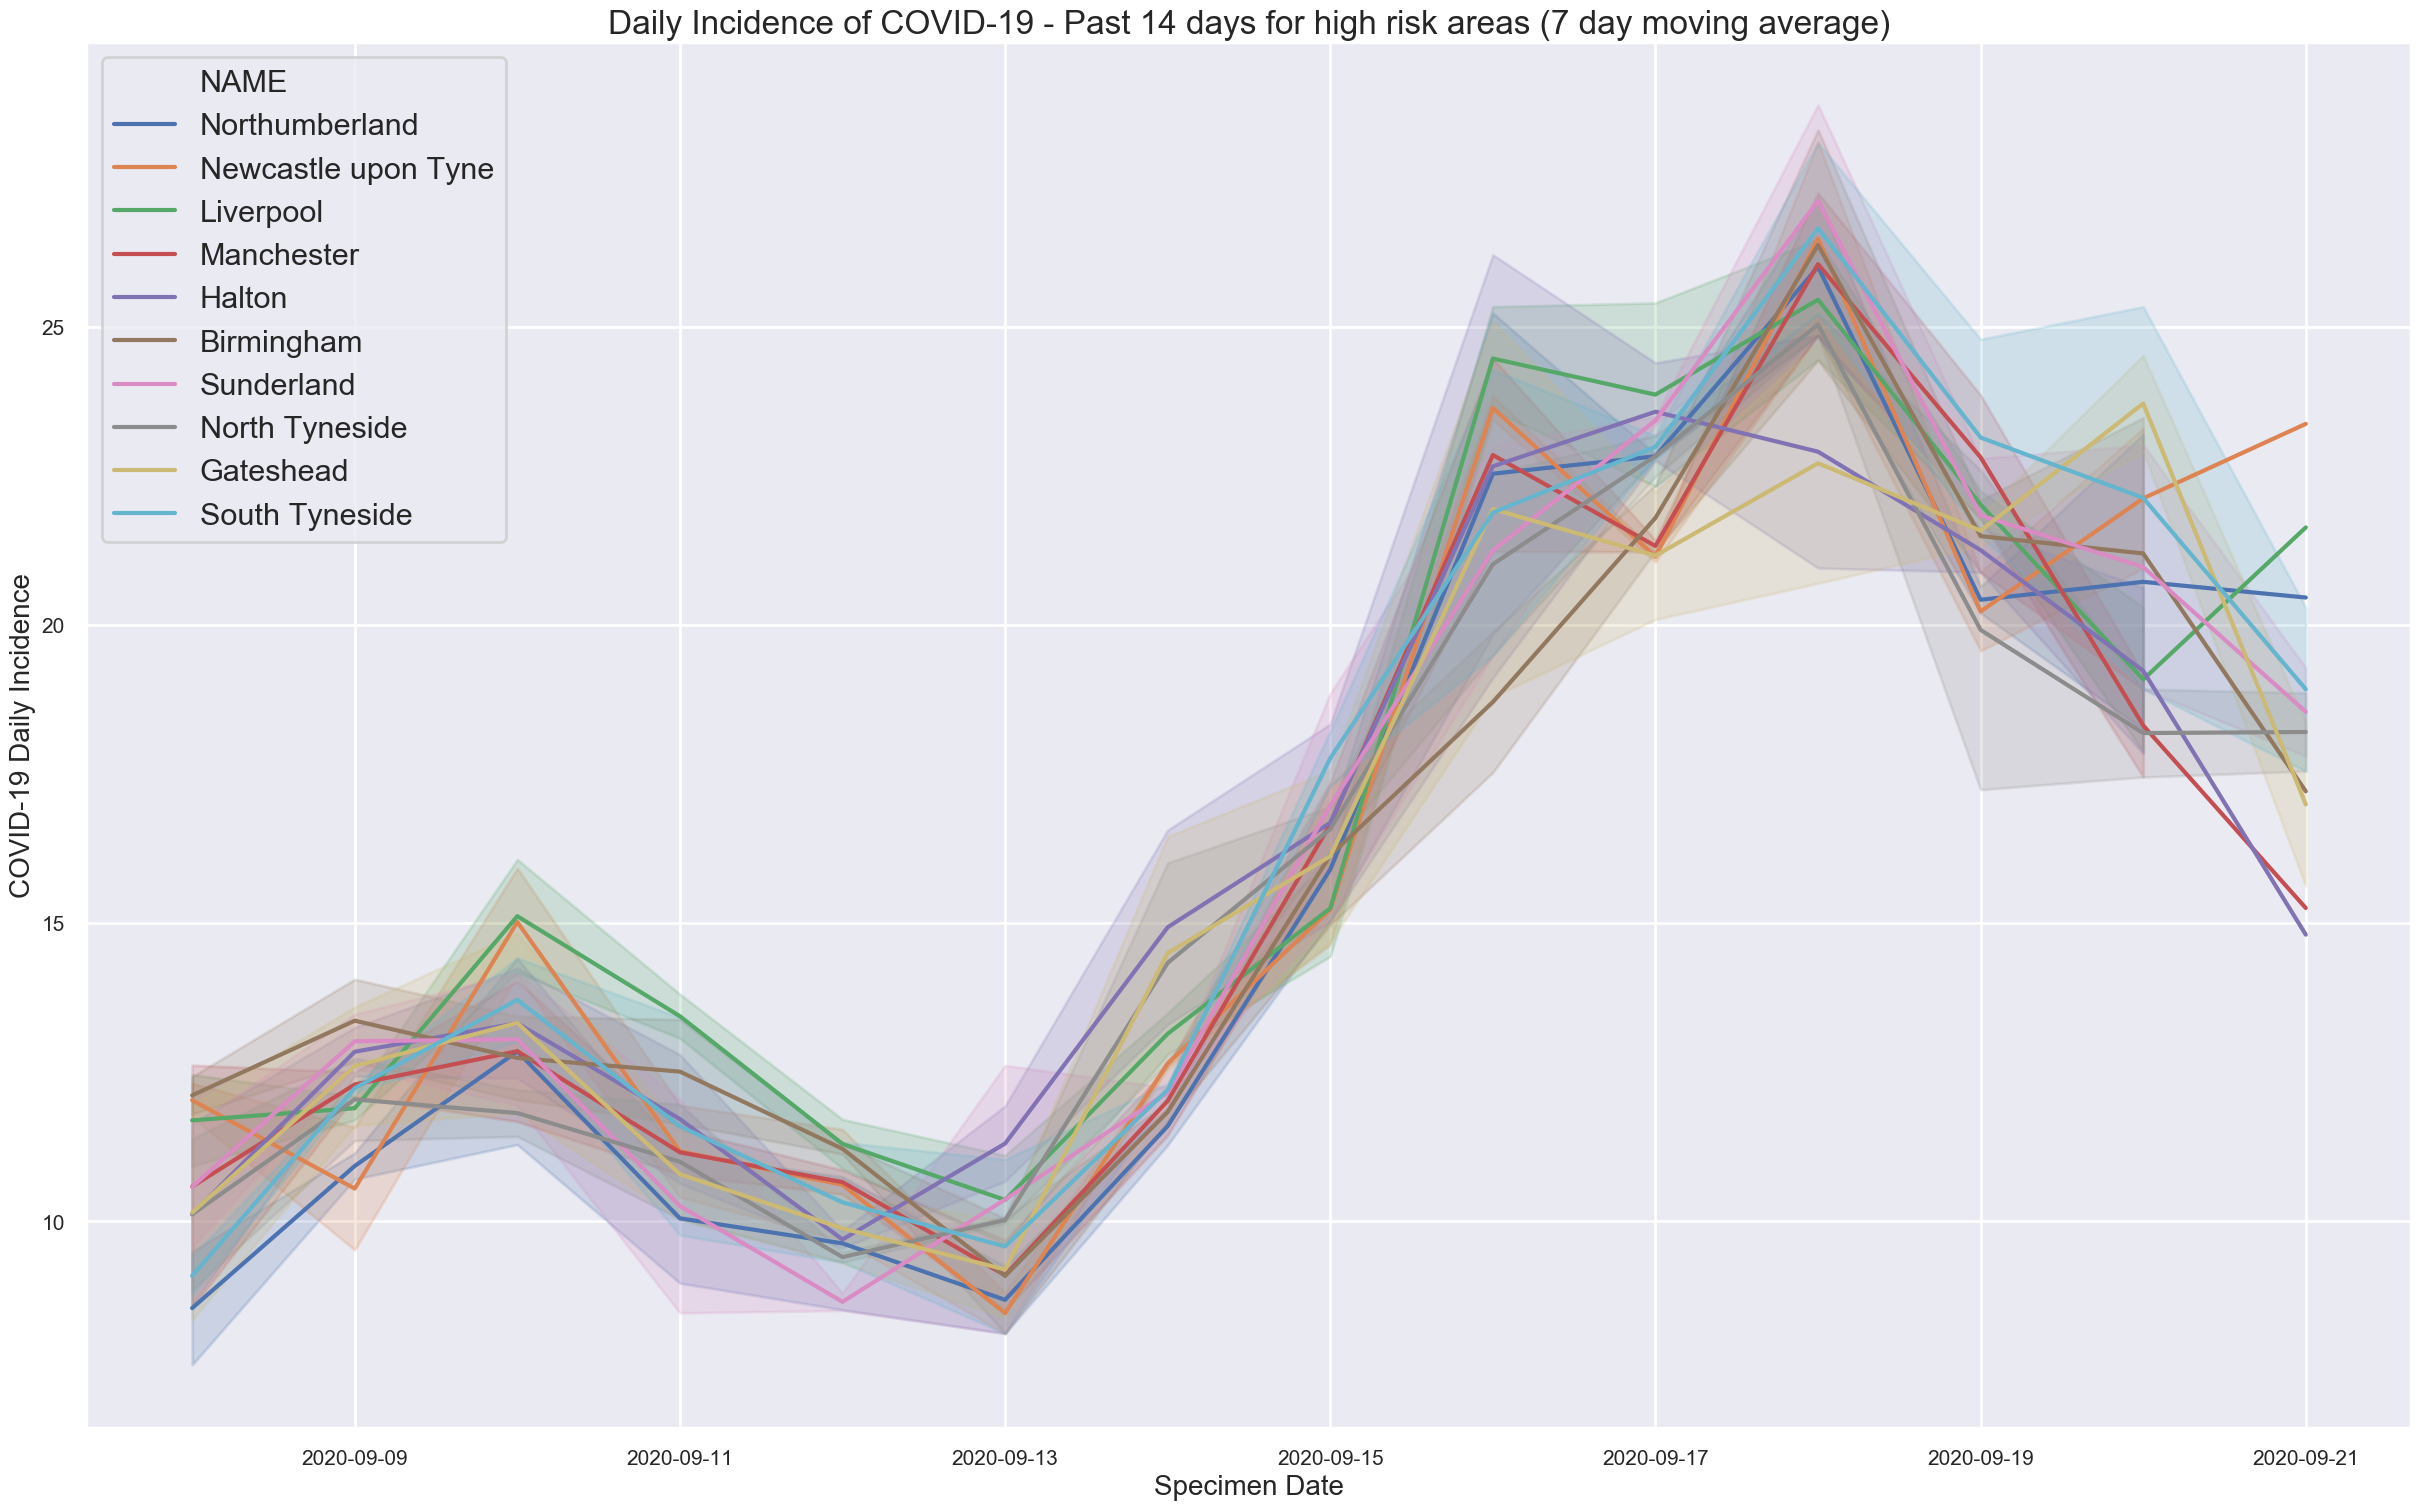

In [582]:
sns.set()
sns.set_context("poster")
plt.figure(figsize = (30,18))
plt.rcParams["axes.labelsize"] = 20
plt.tick_params(labelsize = 15)
plt.title('Daily Incidence of COVID-19 - Past 14 days for high risk areas (7 day moving average)')
ax = sns.lineplot(x="SPECIMEN_DATE", y="MA", hue="NAME", data=atriskdf)
ax.set(xlabel="Specimen Date", ylabel = "COVID-19 Daily Incidence")
plt.show();

We're now interested in the number of care homes that may be affected for such areas. We again take the high risk area codes and this time look at plotting the care home counts for each.

In [583]:
care_home_counts = atriskdf.groupby('NAME')['CARE_HOMES_PER_100000'].mean().reset_index()

In [584]:
care_home_counts = care_home_counts.sort_values(by = 'CARE_HOMES_PER_100000', ascending = True)

In [585]:
latestday = str(latestday)

In [586]:
latestday = latestday[:10]

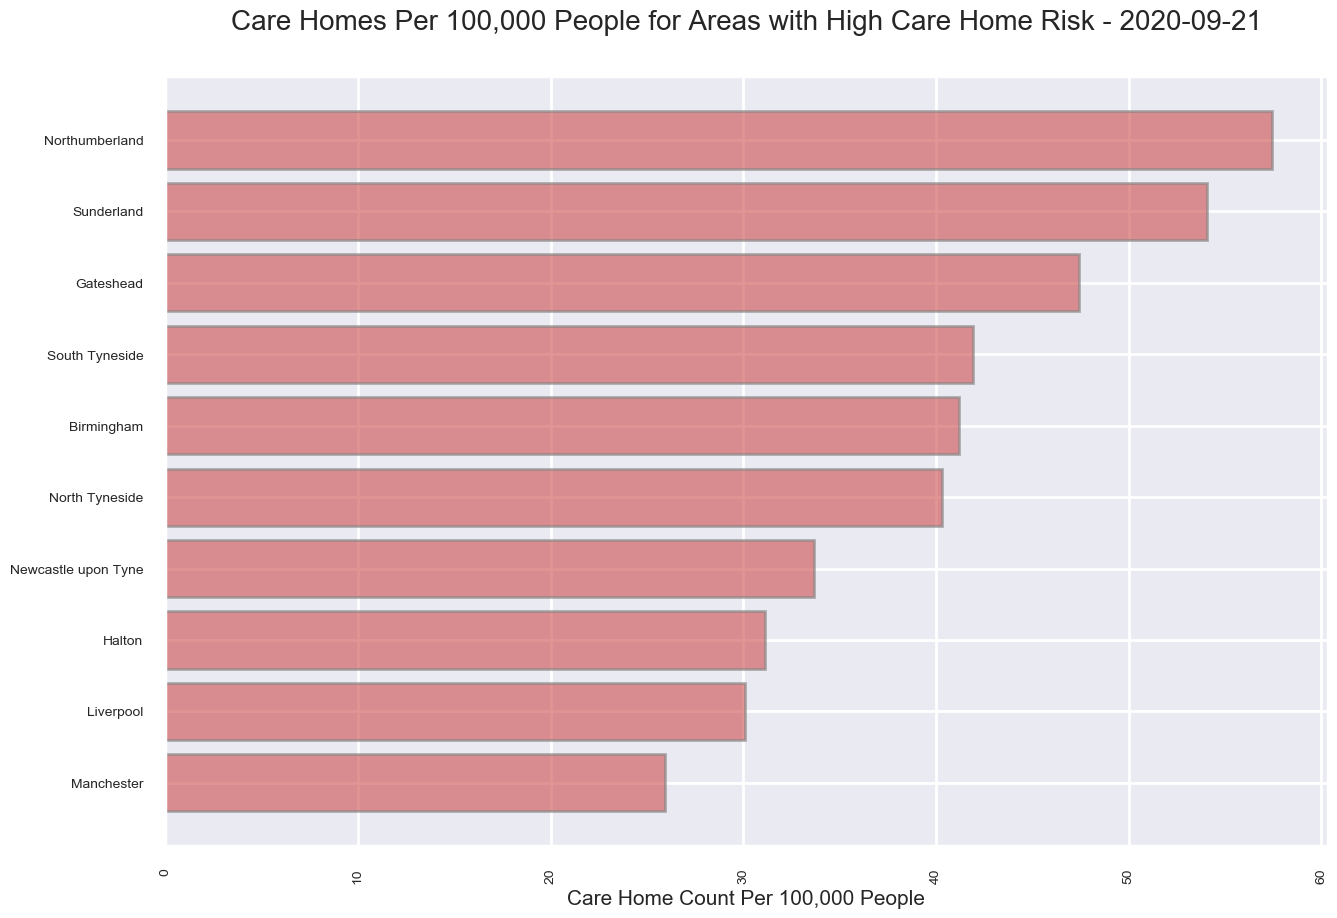

In [587]:
plt.figure(figsize = (15,10))
plt.title( 'Care Homes Per 100,000 People for Areas with High Care Home Risk' + ' ' + '-' + " " + str(latestday),
         fontsize = 20, y = 1.05)
plt.barh(care_home_counts['NAME'],care_home_counts['CARE_HOMES_PER_100000'],color = (0.8, 0.3, 0.3, 0.1),
         alpha = 0.6, edgecolor = 'grey')
plt.xticks(rotation = 90, fontsize = 10)
plt.rcParams['figure.facecolor'] = 'white'
plt.yticks(fontsize = 10)
plt.xlabel('Care Home Count Per 100,000 People', fontsize = 15)
plt.show();

At the date of this analysis, it would seem as though protecting Northumberland's care homes should be a priority. It is a high risk area and of such areas clearly has the greatest number of care homes per 100,000 people present in it.

## Geo Plots

It can often be more helpful to visualise the situation geographically to establish if any particular regions have a larger care home risk. We start this process by loading in the below shape file (Counties and Unitary Authorities Boundaries). This can be downloaded here: https://geoportal.statistics.gov.uk/datasets/43b324dc1da74f418261378a9a73227f_0

In [588]:
shpfile = gpd.read_file('Counties_and_Unitary_Authorities__December_2019__Boundaries_UK_BFC.shx')

In [589]:
shpfile.head()

,objectid,ctyua19cd,ctyua19nm,ctyua19nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.676140,9.371262e+07,71011.933949,"MULTIPOLYGON (((447213.900 537036.104, 447228...."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.388156e+07,44481.691242,"MULTIPOLYGON (((448609.900 521982.600, 448616...."
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.567520,2.450695e+08,96703.989701,"MULTIPOLYGON (((455932.335 527880.697, 455919...."
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.556911,2.049330e+08,123408.985928,"MULTIPOLYGON (((444157.002 527956.304, 444165...."
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.535339,1.974757e+08,107206.401677,"POLYGON ((423496.602 524724.299, 423497.204 52..."


The strange looking data above basically describes the geography and border outlines for each of the upper tier local authorities in the UK. It also contains their codes which means eventually we can easily merge this with our care homes table to populate it with our care home risk measurements.

As well as having shaded regions, we would also like the centroids of the local authorities to display the number of care homes. The following manipulations will help us to be able to plot these eventually.

In [590]:
geo_data = shpfile

In [591]:
geo_data.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

Reproject the geometries by replacing the values with projected ones

In [592]:
geo_data_proj = geo_data.copy()


geo_data_proj['geometry'] = geo_data_proj['geometry'].to_crs(epsg=4326)

In [593]:
crs = {'init' : 'epsg:4326'}

In [594]:
geometry = [Point(xy) for xy in zip( geo_data['long'], geo_data['lat'])]

In [595]:
geo_df = gpd.GeoDataFrame(geo_data, crs = crs, geometry = geometry)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Create our map dataframes for plotting

In [596]:
CHRiskMap = CHRisk.rename(columns={"AREA_CODE":"ctyua19cd"})

In [597]:
Map1 = pd.merge(geo_df, CHRiskMap, on='ctyua19cd')

In [598]:
Map1.head()

,objectid,ctyua19cd,ctyua19nm,ctyua19nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,...,NAME,CARE_HOMES_PER_100000,POPULATION,AVG_INCIDENCE_14_DAYS,LATEST_CUMULATIVE_INCIDENCE,AVG_DAILY_CHANGE_14_DAYS,AVG_INCIDENCE_14_DAYS_MM,LATEST_CUMULATIVE_INCIDENCE_MM,AVG_DAILY_CHANGE_14_DAYS_MM,CARE_HOME_RISK_MM
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.676140,9.371262e+07,71011.933949,...,Hartlepool,43.971601,93242,9.728908,905.171489,0.238328,0.324629,905.171490,0.534667,0.000192
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.388156e+07,44481.691242,...,Middlesbrough,45.537017,140545,7.165981,947.739158,0.289877,0.233434,947.739159,0.563392,0.000139
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.567520,2.450695e+08,96703.989701,...,Redcar and Cleveland,53.394579,136718,4.075124,648.049269,0.189631,0.123454,648.049270,0.507530,0.000097
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.556911,2.049330e+08,123408.985928,...,Stockton-on-Tees,36.508749,197213,5.686383,639.410181,0.056341,0.180787,639.410182,0.433253,0.000122
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.535339,1.974757e+08,107206.401677,...,Darlington,46.919280,106566,4.289763,671.884091,0.139020,0.131092,671.884092,0.479327,0.000094


In [599]:
Map2 = pd.merge(geo_data_proj, CHRiskMap, on='ctyua19cd')

In [600]:
Map2.head()

,objectid,ctyua19cd,ctyua19nm,ctyua19nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,...,NAME,CARE_HOMES_PER_100000,POPULATION,AVG_INCIDENCE_14_DAYS,LATEST_CUMULATIVE_INCIDENCE,AVG_DAILY_CHANGE_14_DAYS,AVG_INCIDENCE_14_DAYS_MM,LATEST_CUMULATIVE_INCIDENCE_MM,AVG_DAILY_CHANGE_14_DAYS_MM,CARE_HOME_RISK_MM
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.676140,9.371262e+07,71011.933949,...,Hartlepool,43.971601,93242,9.728908,905.171489,0.238328,0.324629,905.171490,0.534667,0.000192
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.388156e+07,44481.691242,...,Middlesbrough,45.537017,140545,7.165981,947.739158,0.289877,0.233434,947.739159,0.563392,0.000139
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.567520,2.450695e+08,96703.989701,...,Redcar and Cleveland,53.394579,136718,4.075124,648.049269,0.189631,0.123454,648.049270,0.507530,0.000097
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.556911,2.049330e+08,123408.985928,...,Stockton-on-Tees,36.508749,197213,5.686383,639.410181,0.056341,0.180787,639.410182,0.433253,0.000122
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.535339,1.974757e+08,107206.401677,...,Darlington,46.919280,106566,4.289763,671.884091,0.139020,0.131092,671.884092,0.479327,0.000094


The following little trick will make the plot nicer to visualise with the colour scheme we will use.

In [601]:
Map2['CARE_HOME_RISK_MM'] = -Map2['CARE_HOME_RISK_MM']

We're now ready to plot. You can see this plot is essentially two plotted together using the two map frames we created just earlier.

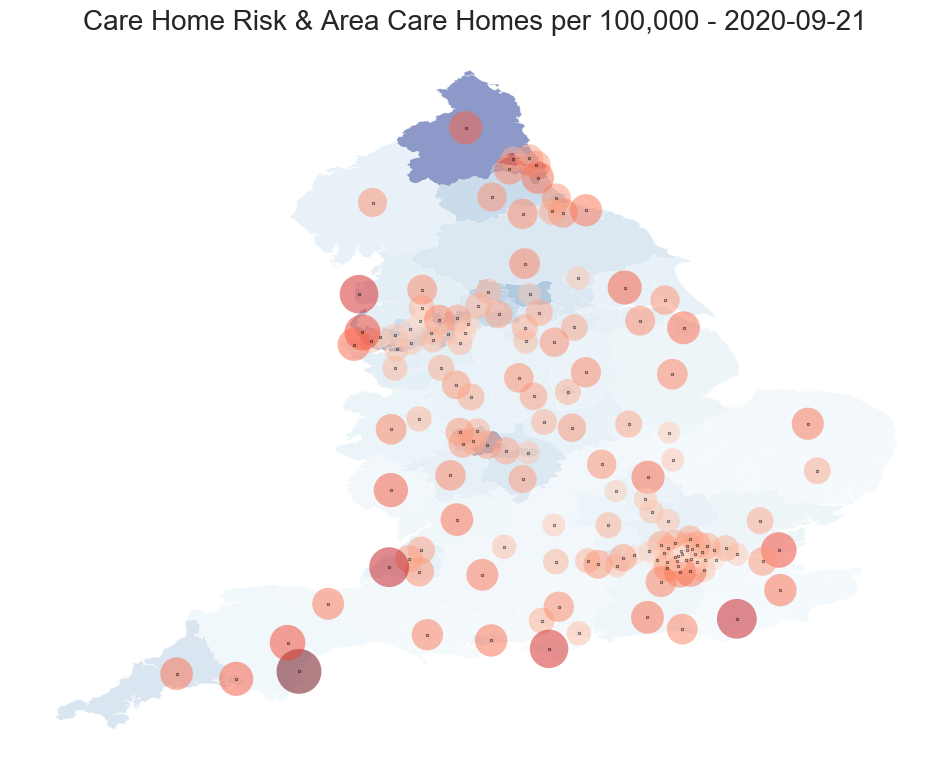

In [602]:
fig, ax = plt.subplots(figsize= (12,12))

ax.set_aspect('equal')

Map2.plot(ax = ax, column="CARE_HOME_RISK_MM", cmap='BuPu_r', edgecolor = 'white', linewidth = 0.1)

Map1.plot(ax = ax, column = 'CARE_HOMES_PER_100000', s = Map1['CARE_HOMES_PER_100000']*10, alpha = 0.5, cmap = 'Reds', linewidth = 0.05)

Map1.plot(ax=ax, c='black', markersize = 0.1)

plt.grid(b=None)
plt.axis('off')
plt.title("Care Home Risk & Area Care Homes per 100,000" + " " + "-" + " " + str(latestday), fontsize=20)

plt.show();

Above, the darker purple areas represent current areas of higher risk, and larger red circles at every centroid are indicative of a larger number of care homes per 100,000 people.

To get an idea of risk alone, we can plot again without the centroids this time.

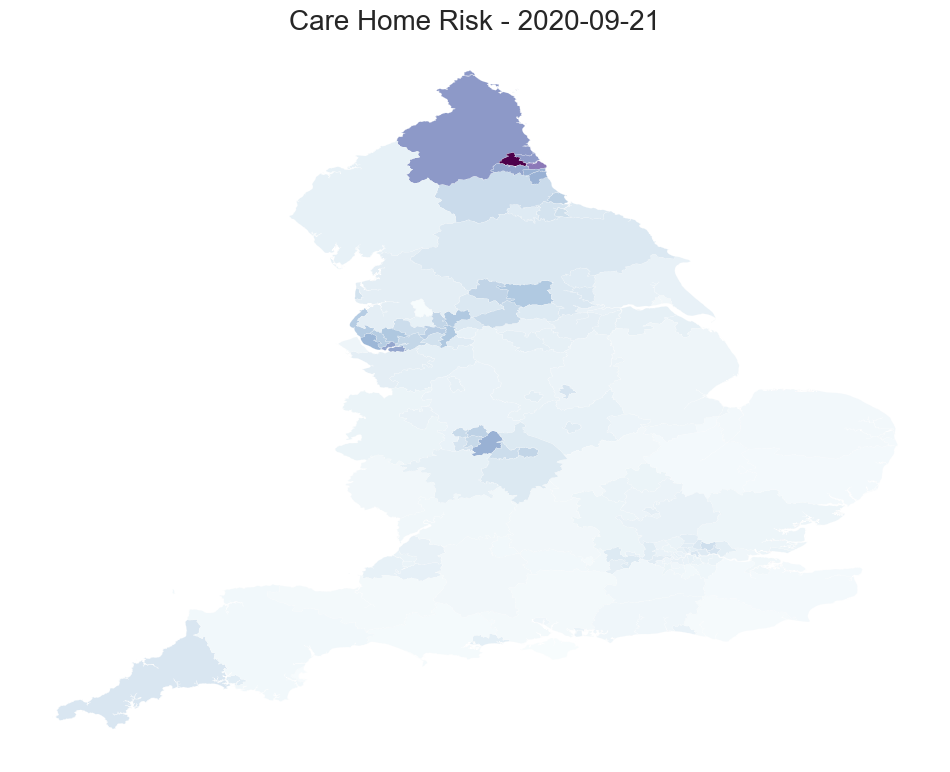

In [603]:
fig, ax = plt.subplots(figsize= (12,12))

ax.set_aspect('equal')

Map2.plot(ax = ax, column="CARE_HOME_RISK_MM", cmap='BuPu_r', edgecolor = 'white', linewidth = 0.1)



plt.grid(b=None)
plt.axis('off')
plt.title("Care Home Risk" + " " + "-" + " " + str(latestday), fontsize=20)

plt.show();

It's clearer now from here that areas of concern are the Merseyside and Liverpool areas as well as a few areas in the North East of England.

That brings us to the end of this analysis. There is a lot more that can be done with this data, and I would encourage you to expand on this analysis with the APIs that we have provided.